# Play to obtain similar foracaste results using Holt-Winters Vs Linear Regression

**Problem Statement:** For time series forcasting can I get similar forcast results to Holt-Winters method using linear regression?

The assumption is that, if I broke the time stamp into it's components and treated them as features a Linear Regression model can predict future instances based on time stamp.

I'll decompose the timestamp in this case into:
1. Year (starting from 1)
2. Month (1 - 12)
3. Sequence (1, 2, 3, ....) *to maintain the sequence of events* 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression

In [3]:
data = pd.read_csv('airline_passengers.csv', index_col = 'Month', parse_dates=True)
data.index.freq = 'MS'

In [4]:
train_data = data.iloc[:108]
test_data = data.iloc[108:]
train_data = train_data.astype('double')

In [5]:
fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],
                                    trend='mul',
                                    seasonal='mul',
                                    seasonal_periods= 12).fit()
y_pred = fitted_model.forecast(36)

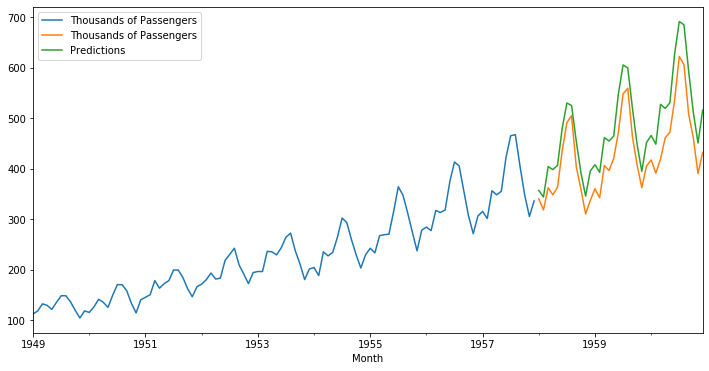

In [6]:
train_data['Thousands of Passengers'].plot(legend = True, figsize=(12,6))
test_data['Thousands of Passengers'].plot(legend=True)
y_pred.plot(legend=True, label='Predictions')

In [7]:
print(f'Mean Absolute Error:  {mean_absolute_error(test_data, y_pred)}')
print(f'Mean Squared Error:  {mean_squared_error(test_data, y_pred)}')

Mean Absolute Error:  53.16361991340851
Mean Squared Error:  3200.583445912333


# Replicate with Regression

### It would be great if I made it work!

In [8]:
# Split the datestamp's components into features
data['year'] = data.index.year
data['month'] = data.index.month
data['year'] = data['year']-1948
data['no']= range(1, len(data)+1)

In [9]:
data.head(2)

,Thousands of Passengers,year,month,no
Month,,,,
1949-01-01,112,1,1,1
1949-02-01,118,1,2,2


In [10]:
# # Apply feature scaling - didn't add much value!
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# data[['Thousands of Passengers', 'year', 'month', 'no']]=ss.fit_transform(data)

In [11]:
# Split data
X_train = data.drop('Thousands of Passengers', axis=1).iloc[:108]
X_test = data.drop('Thousands of Passengers', axis=1).iloc[108:]
y_train = data['Thousands of Passengers'].iloc[:108]
y_test = data['Thousands of Passengers'].iloc[108:]

In [12]:
X_train.shape , X_test.shape , y_train.shape, y_test.shape

((108, 3), (36, 3), (108,), (36,))

In [13]:
# Fit a Linear Regression model
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [14]:
print(f'Mean Absolute Error:  {mean_absolute_error(y_test, y_pred)}')
print(f'Mean Squared Error:  {mean_squared_error(y_test, y_pred)}')

Mean Absolute Error:  53.627506546951
Mean Squared Error:  4996.04656009285


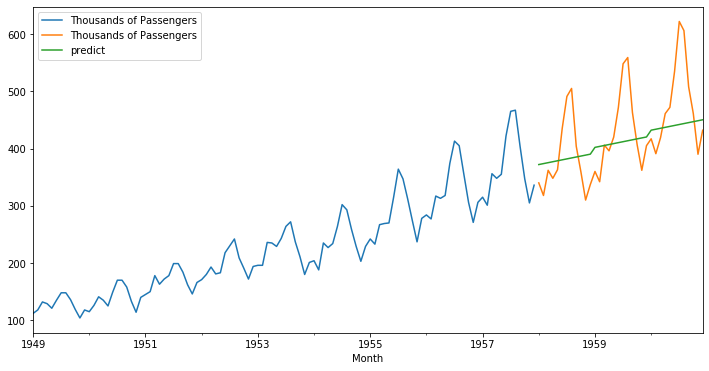

In [15]:
# Adding predictions to reality DataFrame
predictions = pd.DataFrame(y_test)
predictions['predict']=y_pred

# Plot predictions Vs test set
y_train.plot(figsize= (12,6), legend=True)
predictions['Thousands of Passengers'].plot(legend=True)
predictions['predict'].plot(legend=True)

### Understanding what can be improved

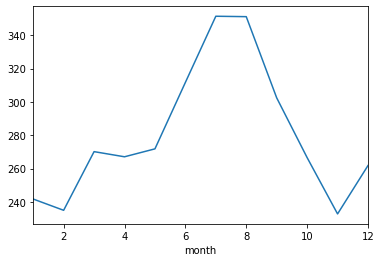

In [16]:
data.groupby('month').mean()['Thousands of Passengers'].plot()

month
11    232.833333
2     235.000000
1     241.750000
12    261.833333
10    266.583333
4     267.083333
3     270.166667
5     271.833333
9     302.416667
6     311.666667
8     351.083333
7     351.333333
Name: Thousands of Passengers, dtype: float64


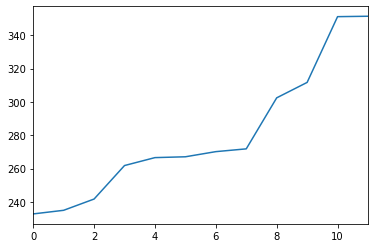

In [17]:
print(data.groupby('month').mean()['Thousands of Passengers'].sort_values())
pd.Series(data.groupby('month').mean()['Thousands of Passengers'].sort_values().values).plot()

## Learning!
I beleive if we found a way for the month the fit linear model, we can succeed (e.g. coding or polinomial Reg)

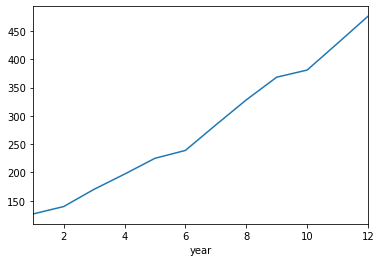

In [18]:
data.groupby('year').mean()['Thousands of Passengers'].plot()

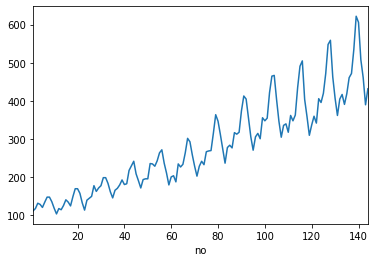

In [19]:
data.groupby('no').mean()['Thousands of Passengers'].plot()

## Renaming months for better linearity

In [20]:
# Label encoding months to follow '.....'
month_data = pd.DataFrame(data.groupby('month').mean()['Thousands of Passengers'].sort_values())
month_data['month']=month_data.index
month_data['month_re']= range(1, len(month_data)+1)
month_data.index.rename('ind', inplace=True)

In [21]:
# Add new coded months to the dataset
data_2 = pd.merge(data, month_data[['month', 'month_re']], on='month' , how='left').drop('month', axis=1)
data_2.index = data.index
data_2.head()

,Thousands of Passengers,year,no,month_re
Month,,,,
1949-01-01,112,1,1,3
1949-02-01,118,1,2,2
1949-03-01,132,1,3,7
1949-04-01,129,1,4,6
1949-05-01,121,1,5,8


In [22]:
# Split data
X_train = data_2.drop('Thousands of Passengers', axis=1).iloc[:108]
X_test = data_2.drop('Thousands of Passengers', axis=1).iloc[108:]
y_train = data_2['Thousands of Passengers'].iloc[:108]
y_test = data_2['Thousands of Passengers'].iloc[108:]

In [23]:
X_train.shape , X_test.shape , y_train.shape, y_test.shape

((108, 3), (36, 3), (108,), (36,))

In [24]:
# Fit a Linear Regression model
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [25]:
print(f'Mean Absolute Error:  {mean_absolute_error(y_test, y_pred)}')
print(f'Mean Squared Error:  {mean_squared_error(y_test, y_pred)}')

Mean Absolute Error:  33.17023148148147
Mean Squared Error:  2305.63966498225


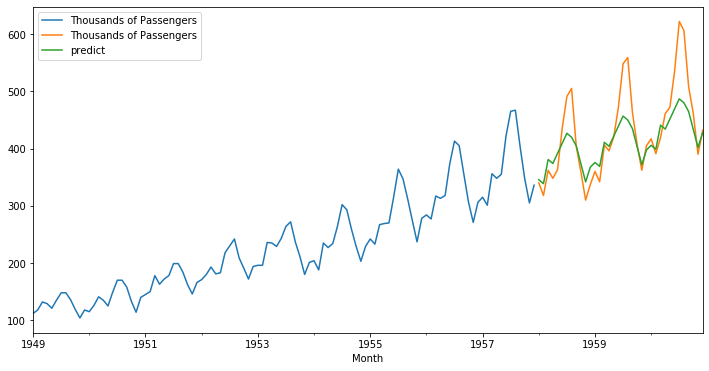

In [26]:
# Adding predictions to reality DataFrame
predictions = pd.DataFrame(y_test)
predictions['predict']=y_pred

# Plot predictions Vs test set
y_train.plot(figsize= (12,6), legend=True)
predictions['Thousands of Passengers'].plot(legend=True)
predictions['predict'].plot(legend=True)

In [28]:
data_2 = data_2.drop('no', axis=1)

In [30]:
# Split data
X_train = data_2.drop('Thousands of Passengers', axis=1).iloc[:108]
X_test = data_2.drop('Thousands of Passengers', axis=1).iloc[108:]
y_train = data_2['Thousands of Passengers'].iloc[:108]
y_test = data_2['Thousands of Passengers'].iloc[108:]

In [31]:
# Fit a Linear Regression model
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [32]:
print(f'Mean Absolute Error:  {mean_absolute_error(y_test, y_pred)}')
print(f'Mean Squared Error:  {mean_squared_error(y_test, y_pred)}')

Mean Absolute Error:  34.42857132579353
Mean Squared Error:  2375.9401757364676


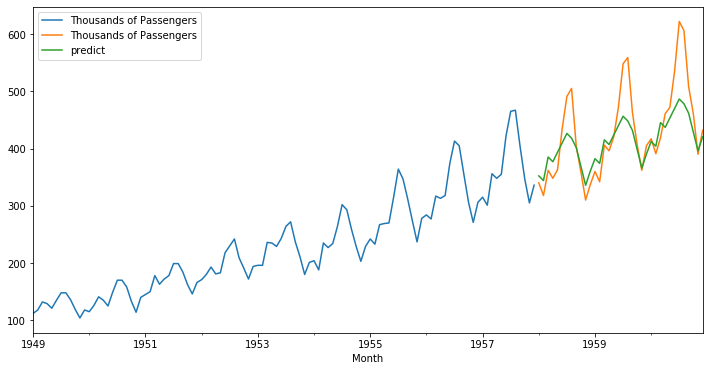

In [33]:
# Adding predictions to reality DataFrame
predictions = pd.DataFrame(y_test)
predictions['predict']=y_pred

# Plot predictions Vs test set
y_train.plot(figsize= (12,6), legend=True)
predictions['Thousands of Passengers'].plot(legend=True)
predictions['predict'].plot(legend=True)